# This to classify arabic dialects, Egybtion,Not Egyption,Iraqi,Not Iraqi

## Imports
### Here, all required packages in this project will be imported.

In [1]:
# This code is to disable warnings that may display this notebook a little bit "ugly"
import warnings
warnings.filterwarnings('ignore')

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from sklearn.pipeline import Pipeline

import string

from sklearn.learning_curve import learning_curve

from ipywidgets import widgets
from IPython.display import display
from IPython.display import clear_output

from collections import Counter

import pickle

import sys

import random

%matplotlib inline

## get the data

In [3]:
iraq = pd.read_excel(open('10K egypt - iraq.xlsx','rb'), sheetname=0)
egypt = pd.read_excel(open('10K egypt - iraq.xlsx','rb'), sheetname=1)
data = [iraq,egypt]
data = pd.concat(data)

## EDA

In [4]:
data.tail(2)

,text,label
9998,RT @n_h996: فولو للاكونت ده 👇 @n_h996 ورتويت ...,Egyptian
9999,RT @Soll__a: الحب هو انك برغم كل اللخبطه اللى ...,Egyptian


In [5]:
data.head(2)

,text,label
0,@q56KeugK7R4c8H6 @PonRuTrDQO6m8Nn بخطف عليكم ب...,not-iraqi
1,@7ellooha @marimalazraa قد ميز الله - تعالى - ...,iraqi


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 9999
Data columns (total 2 columns):
text     19997 non-null object
label    20000 non-null object
dtypes: object(2)
memory usage: 468.8+ KB


## data cleaning

In [7]:
import re

def delete_mentions(mess):
    mess = str(mess)
    if mess is not None and len(mess) > 0:
        return re.sub(r"(RT )?@[a-zA-Z0-9_]+:? ",r"",mess)
    else:
        return ""
def remove_links(string):
    return (re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string))

def remove_emojis(string):
    emoji_pattern = re.sub("[^"
                           u"\U00000621-\U0000064A"
                           "\s"
                           "]+", "",string)
    return emoji_pattern.strip()

### remove mentions

In [8]:
delete_mentions('@q56KeugK7R4c8H6 @PonRuTrDQO6m8Nn بخطف عليكم ب.')

'بخطف عليكم ب.'

In [9]:
data['text'] = data['text'].apply(delete_mentions)

### remove links

In [10]:
remove_links("@7ellooha @marimalazraa قد ميز الله - تعالى - هذه الأمة بالإسلام وأعزها به، وجعله لها طريقة فريدة في العيش، وطرازاً… https://t.co/VSNs0du8bN")

'@7ellooha @marimalazraa قد ميز الله - تعالى - هذه الأمة بالإسلام وأعزها به، وجعله لها طريقة فريدة في العيش، وطرازاً… '

In [11]:
data['text'] = data['text'].apply(remove_links)

### remove emojis

In [12]:
remove_emojis("بخطف عليكم بسرعه ١٨٠ وايدي برع جامه وشرب ديو 😃...	")

'بخطف عليكم بسرعه  وايدي برع جامه وشرب ديو'

In [13]:
data['text'] = data['text'].apply(remove_emojis)

In [14]:
data.head(10)

,text,label
0,بخطف عليكم بسرعه وايدي برع جامه وشرب ديو,not-iraqi
1,قد ميز الله تعالى هذه الأمة بالإسلام وأعزها ...,iraqi
2,انت شكو,iraqi
3,احلا عجميه اكثر اكاونت ابوق منه خوش وحده طيبه ...,iraqi
4,جزا الله خوش ر خدا ناه م ر,not-iraqi
5,بش باد ه خبر خوشتر از خبر آزاد ضانبو ه روز زبا...,not-iraqi
6,حكام الشيعة سراق النفط في العراق لا يبالون الى...,iraqi
7,هههههههه حتى المؤشرات تأكد ذالك ب تا شكون داها...,iraqi
8,باين عليه شكون وليد الحركي هذا إذا كنت اصلا جز...,iraqi
9,خوش تهديد,iraqi


### delete arabic stop words

In [16]:
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))

In [17]:
print(arb_stopwords)

{'آه', 'التي', 'أينما', 'اللائي', 'كما', 'ذاك', 'ممن', 'هيا', 'بكما', 'ذه', 'كليهما', 'يا', 'ومن', 'عسى', 'كيت', 'ذات', 'لكيلا', 'بكم', 'كلا', 'غير', 'في', 'هن', 'هذان', 'بلى', 'بهم', 'هاتان', 'أكثر', 'كيفما', 'لاسيما', 'لسن', 'كذا', 'اللذان', 'مما', 'أنا', 'كأنما', 'إما', 'كيف', 'ماذا', 'ليس', 'بخ', 'وإذ', 'منها', 'إذ', 'ذواتي', 'أف', 'أما', 'تلكم', 'أولاء', 'ليستا', 'كأن', 'هذا', 'لسنا', 'لم', 'أين', 'متى', 'ليسوا', 'أم', 'ذي', 'إليكما', 'ذينك', 'إذن', 'لو', 'هذين', 'حبذا', 'تين', 'كأين', 'لكم', 'بل', 'شتان', 'قد', 'منذ', 'ذلكما', 'أولئك', 'لكنما', 'هما', 'ذانك', 'هيت', 'لستما', 'منه', 'أوه', 'إنه', 'حاشا', 'هاهنا', 'هاته', 'كل', 'هؤلاء', 'إي', 'حيثما', 'ذلكن', 'اللذين', 'وما', 'ما', 'ذان', 'أنى', 'لستم', 'بماذا', 'لي', 'هي', 'فإن', 'على', 'فإذا', 'إنا', 'عن', 'كلتا', 'سوى', 'لهم', 'ها', 'أنت', 'بين', 'هل', 'من', 'بعد', 'حتى', 'لن', 'إلى', 'ألا', 'لعل', 'بها', 'بما', 'فلا', 'كلاهما', 'تينك', 'كم', 'لولا', 'إلا', 'هاتين', 'بيد', 'لا', 'كذلك', 'به', 'ليت', 'إليك', 'لستن', 'تي', 'لكن', 

In [18]:
def delete_stop_words(mess):
    
    # Now just remove any stopwords
    stop_words = set(nltk.corpus.stopwords.words("arabic"))
    
    return ' '.join(word for word in mess.split() if word not in stop_words and len(word)>1)

In [19]:
delete_stop_words("قد ميز الله - تعالى - هذه الأمة بالإسلام وأعزها س به، وجعله لها طريقة فريدة في العيش، وطرازاً")

'ميز الله تعالى الأمة بالإسلام وأعزها به، وجعله طريقة فريدة العيش، وطرازاً'

In [20]:
data['text'] = data['text'].apply(delete_stop_words)

### delete any word if its length less than 2

In [21]:
data = data[data.text.map(len) > 2]

In [22]:
data.groupby('label').describe()

text
label                                                                 
Egyptian     count                                                8951
             unique                                               6993
             top     عاوز تكبر اكونتك ثواني سهله جدا اعملي فولو ورت...
             freq                                                   81
Not Egyptian count                                                 867
             unique                                                796
             top     والشعراء يتبعهم الغاوون ألم تر أنهم واد يهيمون...
             freq                                                    6
iraqi        count                                                4928
             unique                                               4531
             top     درى اللي مريت مو صدفة ماكو صدفة شوية يلاحقني ز...
             freq                                                   41
not-iraqi    count                                                4810
             unique                                               4193
             top     وعلم السلام ورحم الل صبح بخر مش خوش خوشا بان د...
             freq                                                   42

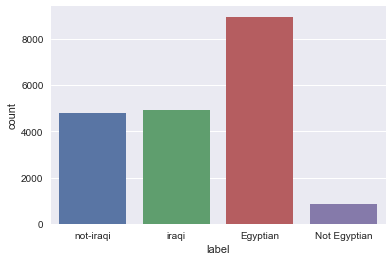

In [23]:
sns.countplot(x="label", data=data)

## Words Representation

### The following code is to show the most representative words per each CATEGORY. While the following code will plot the most representative words per each CATEGORY.

Corpus Size: 58494ormed! Please wait ...

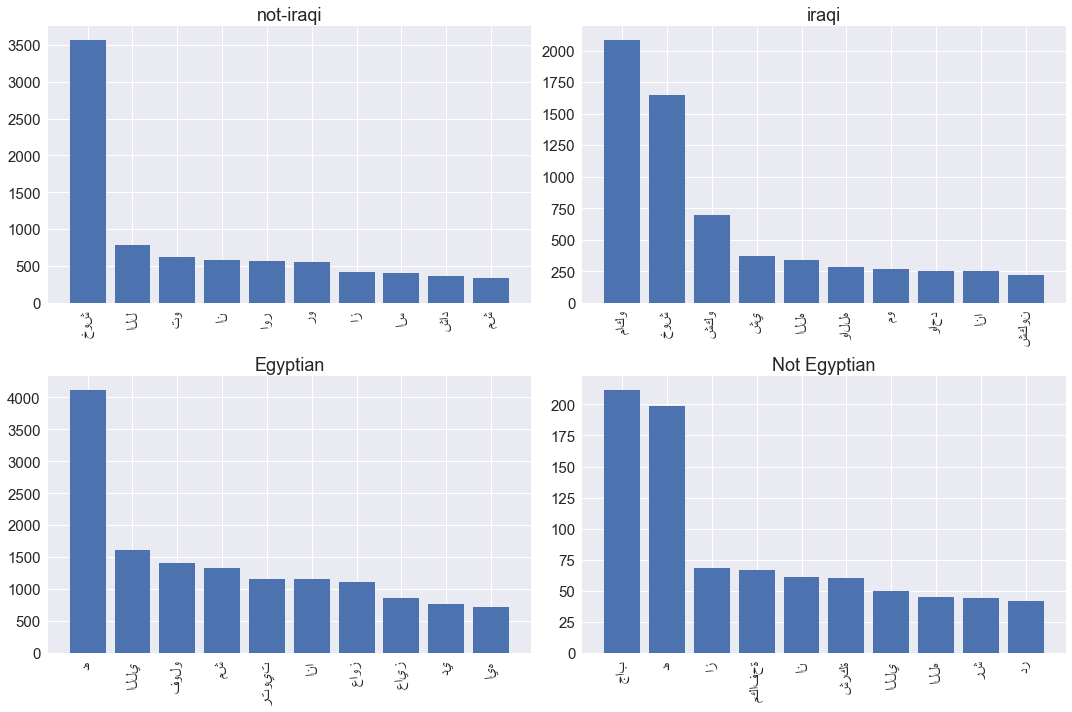

In [24]:
caption_0 = widgets.Label('Enter a number:')
text_0 = widgets.IntText(value=10)
button_0 = widgets.Button(description="Plot")
display(caption_0,text_0,button_0)

def histogram_label():
    n = text_0.value # Top n words
    corpus_size = 0
    i=1
    df = data[['text','label']]
    categories = data.label.unique()
    for category in categories:
            df_text=df.query('label ==  @category')
            result =" ".join(df_text['text'].values.tolist()).split(" ")
            r = pd.DataFrame(result, columns=['WORDS'])
            corpus_size = corpus_size + len(r['WORDS'].unique())
            Counter_=Counter(result).most_common(n)
            labels = [item[0] for item in Counter_]
            number = [item[1] for item in Counter_]
            nbars = len(Counter_)
            plt.subplot(2,2,i)
            plt.xticks(rotation=90,fontsize=15)
            plt.yticks(fontsize=15)
            plt.title(category, fontsize=18)
            plt.bar(np.arange(nbars), number, tick_label=labels)
            i=i+1
    return corpus_size

def handle_submit(sender):
    t = ("Plot is being performed! Please wait ...")
    sys.stdout.write('\r'+t)
    plt.figure(figsize=(15,10))
    s = histogram_label()
    plt.tight_layout()
    sys.stdout.write('\r'+'Corpus Size: ' + str(s))
    sys.stdout.flush()
    
button_0.on_click(handle_submit)

## dialect classification 

In [25]:
X = data.text
y = data.label

In [26]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13689,) (5867,) (13689,) (5867,)


### using naive bayes classification model
#### use pipeline to pipeline the process: convert words to numbers then tfidf to give importance for each word then train the model
#### use pickle to save the model as a file

In [27]:
from sklearn.naive_bayes import MultinomialNB

# Initializing Pipline
pipelineNB = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts   ====  analyzer=normalize_text
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors
])

# Training the model
pipelineNB.fit(X_train, y_train)

# Saving training results using Pickle
with open('pipelineNB.pickle', 'wb') as handle:
    pickle.dump(pipelineNB, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Predictions
predictionsNB = pipelineNB.predict(X_test)

# Model Evaluation
print(classification_report(predictionsNB, y_test))

              precision    recall  f1-score   support

    Egyptian       1.00      0.87      0.93      3118
Not Egyptian       0.04      1.00      0.08        10
       iraqi       0.83      0.93      0.87      1315
   not-iraqi       0.89      0.89      0.89      1424

 avg / total       0.93      0.89      0.91      5867



In [28]:
with open('pipelineNB.pickle', 'rb') as handle:
    NB = pickle.load(handle)
NB.predict(["شكون حالك"])[0]

'iraqi'

In [29]:
NB.predict(["هوا في ايه"])[0]

'Egyptian'

In [30]:
NB.predict(["انا عاوز أوجه تحيه للدوله العميقه اللى كل يوم بتثبت ان البلد دى فيها رجاله عارفه بتعمل ايه فعلا و امتى و ازاى ، فى اسبوعي…"])[0]

'Egyptian'

In [31]:
NB.predict(["انا خوش مشتاقلك"])[0]

'iraqi'

In [32]:
NB.predict(["م نواز شرف اس وقت عوام سب زاد مقبول ترن لر"])[0]

'not-iraqi'

### cross validation

In [33]:
%time scoresNB = cross_val_score(pipelineNB, X_train, y_train, cv = 5)
print("Cross-validation scores: {}".format(scoresNB))
print("Average cross-validation score: {:.2f} +/- {:.2f}".format(scoresNB.mean(), scoresNB.std()))
scoresNB = scoresNB.mean()

CPU times: user 2.46 s, sys: 64.5 ms, total: 2.52 s
Wall time: 2.55 s
Cross-validation scores: [ 0.88353414  0.87399562  0.88422206  0.88093499  0.88596491]
Average cross-validation score: 0.88 +/- 0.00


#### learining curve

In [34]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    This function is to generate a simple plot of the test and traning learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 610 ms, sys: 351 ms, total: 961 ms
Wall time: 7.47 s


<module 'matplotlib.pyplot' from '/Users/mohammedissa/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

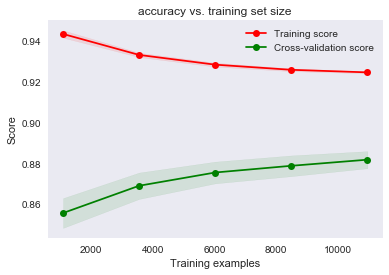

In [35]:
%time plot_learning_curve(pipelineNB, "accuracy vs. training set size", X_train, y_train, cv=5)

#### delete duplicates from data, this may a reason for the week results

In [36]:
data2 = data.drop_duplicates(subset=['text'])

In [37]:
data2.groupby('label').describe()

text
label                                                                 
Egyptian     count                                                6974
             unique                                               6974
             top                                    نفسي محل ورد زي ده
             freq                                                    1
Not Egyptian count                                                 766
             unique                                                766
             top     انجام ارها ادار تو ان مملت مثل مواجهه با ادها ...
             freq                                                    1
iraqi        count                                                4501
             unique                                               4501
             top                                 الاكل الاكل ماكو غيره
             freq                                                    1
not-iraqi    count                                                4176
             unique                                               4176
             top              مبارباد جو اور وال تو اس جس رشت اس ون دا
             freq                                                    1

### not egyption set is much smaller than others, this results to week learning of not egyption

## Not egyption may be Iraqi, and not Iraqi may be Not egyption
### For better accuricy we can work on classify not egyption to Iraqi and not Iraqi then get the corresponds between not Iraqi and Not egyption
### then we will have 3 classes , Egyption, Iraqi, Not Egyption Nor Iraqi